# This notebook creates training data for the FiD Reader module using the MSMARCO medical triples and MedQA queries + answers + options

### Look at data structure needed for training FiD

Each data point should be in the structure of a dict with these indices:
- question: the query. Is a string
- answers: corresponds to the options in MedQA. Is a list of strings, of unspecified dimension
- target: corresponds to the correct answer in MedQA. Is a string
- ctxs: is a list containing passage information:
    - id: the unique pid
    - title: passage title
    - text: the passage itself


In [3]:
import pandas as pd
import json

In [4]:
data_path = "/scratch/s190619/MSMARCO/FiD/FiD/open_domain_data/TQA/"
data_file = "train.json"
with open(data_path + data_file) as json_file:
    data = json.load(json_file)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/s190619/MSMARCO/FiD/FiD/open_domain_data/TQA/train.json'

In [ ]:
data[0]

### Load FZ corpus data

In [5]:
FZ_passages_path = "/scratch/s190619/MSMARCO/Data/FindZebra/" + "collection_FZ_w_titles.tsv"
df_FZ = pd.read_csv(FZ_passages_path, encoding="utf8", sep="\t", header=None, names=["pid","title","passage"])

In [6]:
df_FZ.head()

,pid,title,passage
0,0,Kernicterus,Kernicterusrefers to brain damage that may occ...
1,1,47 XXX syndrome,"47 XXX syndrome, also called trisomy X or trip..."
2,2,Pseudoxanthoma elasticum,"Pseudoxanthoma elasticum, PXE, is an inherited..."
3,3,Smith-Magenis Syndrome,SummaryClinical characteristics.Smith-Magenis ...
4,4,Smith-Lemli-Opitz Syndrome,SummaryClinical characteristics.Smith-Lemli-Op...


### Load ColBERT retrievals
This is probably not needed for training data

In [7]:
retrievals_path = "/scratch/s190619/MSMARCO/Retrievals/dev-test/" + "Ranking_Model1.tsv"
df_retrievals = pd.read_csv(retrievals_path, encoding="utf8", sep="\t", header=None, names=["qid","pid","rank"])

In [8]:
df_retrievals.head()
#df_retrievals["qid"].unique()

,qid,pid,rank
0,0,1724,1
1,0,15978,2
2,0,2624,3
3,0,16332,4
4,0,21257,5


### Load MedQA queries

In [9]:
# MedQA_path = "/scratch/s190619/MSMARCO/MedQA_US/" + "MedQAQueries_disorders_full_v2.csv"
# df_medQA = pd.read_csv(MedQA_path, sep=',', encoding="utf8", index_col=0)
queries_path = "/scratch/s190619/MSMARCO/Data/" + "retrieval_queries_dev-test.tsv"
df_queries = pd.read_csv(queries_path, sep='\t', encoding="utf8", header=None, names=["qid", "query"])

In [10]:
df_queries.head()

,qid,query
0,0,A 5-year-old girl is brought to the emergency ...
1,1,A 19-year-old boy presents with confusion and ...
2,2,A 41-year-old woman presents to her primary ca...
3,3,A 56-year-old man with known coronary artery d...
4,4,A 16-year-old female high school student is br...


### Load detailed MedQA queries with METAMAP CUIs

In [13]:
MedQA_path = "/scratch/s190619/MSMARCO/Data/" + "disorders_table_train.csv"
df_medQA = pd.read_csv(MedQA_path, sep=',', encoding="utf8")#, header=None, names=["qid", "query"])

In [17]:
df_medQA = df_medQA.drop_duplicates(subset=["query"])
df_medQA.head()

,qid,query,answer,options,meta_info,Disorder,CUI,TUI,short_category,long_category,description,cui_METAMAP
0,3,A pulmonary autopsy specimen from a 58-year-ol...,Thromboembolism,"{'A': 'Thromboembolism', 'B': 'Pulmonary ische...",step1,True,C0040038,T046,DISO,Disorders,Pathologic Function,['C0040038']
1,4,A 20-year-old woman presents with menorrhagia ...,Von Willebrand disease,"{'A': 'Factor V Leiden', 'B': 'Hemophilia A', ...",step1,True,C0042974,T047,DISO,Disorders,Disease or Syndrome,['C0042974']
2,5,A 40-year-old zookeeper presents to the emerge...,Scorpion sting,"{'A': 'Aspirin', 'B': 'Oral contraceptive pill...",step1,True,C0238417,T037,DISO,Disorders,Injury or Poisoning,['C0238417']
4,21,An investigator is studying the function of th...,Anorexia,"{'A': 'Hypothermia', 'B': 'Hyperthermia', 'C':...",step1,True,C0003123,T047,DISO,Disorders,Disease or Syndrome,"['C0003123', 'C1971624']"
7,23,A 42-year-old woman is in the hospital recover...,Delirium tremens,"{'A': 'Acute cholangitis', 'B': 'Alcoholic hal...",step1,True,C0001957,T047,DISO,Disorders,Disease or Syndrome,['C0001957']


# Processing

In [18]:
from tqdm.notebook import tqdm
import ast

### MSMARCO medical data processing

In [19]:
from pyspark.sql.functions import countDistinct

In [20]:
# Create pyspark session
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

from pyspark.sql.types import *

schema = StructType([
    StructField("query", StringType()),
    StructField("positive_doc", StringType()),
    StructField("negative_doc", StringType())])


In [21]:
msmarco_medical_path = "/scratch/s190619/Data_etc/Medical_MSMARCO/triples.msmarco.medical.tsv"
MSM_M = spark.read.format('csv').options(header='false',multiline=True,delimiter='\t',encoding='utf-8').schema(schema).load(msmarco_medical_path)
MSM_M.limit(10).toPandas().head()

,query,positive_doc,negative_doc
0,is a little caffeine ok during pregnancy,We don’t know a lot about the effects of caffe...,It is generally safe for pregnant women to eat...
1,how many calories a day are lost breastfeeding,"Not only is breastfeeding better for the baby,...","However, you still need some niacin each day; ..."
2,cancer of the pancreas symptoms,Symptoms of Pancreatic Cancer. Pancreatic canc...,Pancreatic cancer develops as abnormal pancrea...
3,what is the genus of the weeping willow tree,The weeping willow belongs to the Salix genus....,"The kola nut is the fruit of the kola tree, a ..."
4,can polycythemia cause stroke,Polycythemia Vera Complications. If you have P...,Stroke Recovery. Stroke affects everybody diff...


In [22]:
# %%time
# # MSM_M.filter(MSM_M["query"] == "is a little caffeine ok during pregnancy").count()
# MSM_M.select(countDistinct("positive_doc")).show()

In [23]:
%%time
ms_docs = MSM_M.select('positive_doc').distinct().collect()

CPU times: user 228 ms, sys: 68.1 ms, total: 296 ms
Wall time: 3min 52s


In [8]:
%%time
# I think that there are a lot more distinct docs in the negatives, and they might not be related to a medical domain. I will just use the positives

# %%time
# ms_docs_neg = MSM_M.select('negative_doc').distinct().collect()
MSM_M.select(countDistinct("negative_doc")).show()

+----------------------------+
|count(DISTINCT negative_doc)|
+----------------------------+
|                     4839712|
+----------------------------+



In [9]:
%%time
MSM_M.select("negative_doc").distinct().coalesce(1).write.csv("/scratch/s190619/Data_etc/Medical_MSMARCO/MSMARCO_medical_docs_neg.csv")

CPU times: user 71.5 ms, sys: 22.5 ms, total: 94 ms
Wall time: 7min 34s


In [24]:
ms_docs_cl = [x.asDict()["positive_doc"] for x in ms_docs]
f=open('/scratch/s190619/Data_etc/Medical_MSMARCO/MSMARCO_medical_docs.txt','w')
for doc in ms_docs_cl:
    f.write(doc+'\n')

In [25]:
ms_docs_cl = []
f=open('/scratch/s190619/Data_etc/Medical_MSMARCO/MSMARCO_medical_docs.txt','r')
for doc in f:
    ms_docs_cl.append(doc)

In [17]:
schema2 = StructType([StructField("negative_doc", StringType())])

MSM_M_neg = spark.read.format('csv').options(header='false',multiline=True,delimiter=',',encoding='utf-8').schema(schema2)\
             .load("/scratch/s190619/Data_etc/Medical_MSMARCO/MSMARCO_medical_docs_neg.csv")


In [24]:
[print(x.asDict()["negative_doc"]+"\n") for x in list(MSM_M_neg.sample(0.00001).limit(10).collect())]

Contemporary definitions for zafu. noun. a round thick cushion for sitting meditation, sometimes used on top of a mat. Examples. The zafu is ideal for lotus, half-lotus or Burmese style sitting meditation or other postures with your knees down on the zabuton mat. a round thick cushion for sitting meditation, sometimes used on top of a mat.

Virginia Open. The Virginia Open is the Virginia state open golf tournament, open to both amateur and professional golfers. It is organized by the Virginia State Golf Association and the Middle Atlantic section of the PGA of America. It has been played annually since 1924 (except for war years) at a variety of courses around the state.

Create or modify tables or indexes by using a data-definition query. You can create and modify tables, constraints, indexes and relationships by writing data-definition queries in SQL view. This article explains data-definition queries and how to use them to create tables, constraints, indexes, and relationships.

Sw

[None, None, None, None, None, None, None, None, None, None]

In [31]:
ms_docs_cl

['Late hypocalcemia has a number of known causes. It may be connected to calcium and phosphorus levels in the body. It can also be caused by a problem with parathyroid hormone. Parathyroid hormone is made by the parathyroid glands in the neck.\n',
 'The liver and spleen share common blood circulation pathways. Due to the circulatory link between the liver and spleen, many disease processes affect both organs. Infections, blood cell diseases, liver diseases, cancer and inherited disorders can adversely affect the liver and spleen, causing enlargement of both organs. Any disease process that causes ongoing liver inflammation -- or chronic hepatitis -- and subsequent liver scarring can lead to cirrhosis.\n',
 'Symptoms of shingles in the eye. When you have shingles in the eye, the blistering rash will form on your eyelids, forehead, and possibly on the tip or side of your nose. This rash might show up at the same time as the skin rash, or weeks after the skin blisters have gone away. Some

### Functions

In [26]:
from random import sample
from rank_bm25 import BM25Okapi
import json

In [27]:
def reader_data_from_ColBERT_retrievals(medQA, retrievals, FZ, topk = 100):
    assert retrievals[retrievals["qid"] == retrievals.loc[0,"qid"]].shape[0] >= topk
    
    FZ = FZ.set_index('pid')
    
    rdata = []
    error_qids = []
    for i in tqdm(range(medQA.shape[0])):
#     for i in tqdm(range(5)):
        qid = medQA["qid"].iloc[i]
        try:
            rdata_i = {}

            query = medQA["query"].iloc[i]
            answers = list(ast.literal_eval(medQA["options"].iloc[i]).values())
            target = medQA["answer"].iloc[i]
            rdata_i["question"] = query
            rdata_i["answers"] = answers
            rdata_i["target"] = target

            retrievals_tmp = retrievals[retrievals["qid"] == qid]
            retrievals_tmp = retrievals_tmp.join(FZ, on='pid').reset_index()
    #         print(retrievals_tmp.head())
    #         print(retrievals_tmp.tail())
    #         print(retrievals_tmp.shape)
            passage_list = []
            for j in range(topk):
                passages = {}
                passages['id'] = int(retrievals_tmp["pid"].iloc[j])
                passages['title'] = retrievals_tmp["title"].iloc[j]
                passages['text'] = retrievals_tmp["passage"].iloc[j]
                passage_list.append(passages)
            rdata_i["ctxs"] = passage_list

            rdata.append(rdata_i)
        except:
            error_qids.append(qid)
    
    return rdata, error_qids

In [59]:
def HRR(query, answer, ms_docs_cl, N):
    answer = answer.lower()
    corpus = [x for x in ms_docs_cl if answer in x.lower()]
    if len(corpus) > 0:
        tokenized_corpus = [doc.lower().replace("\n","").split(" ") for doc in corpus]
        bm25 = BM25Okapi(tokenized_corpus)
        tokenized_query = query.split(" ")
        doc_scores = bm25.get_scores(tokenized_query)
        #N = min(len(doc_scores[np.where(doc_scores>doc_scores.max()/2)]),10)
        relevant_passages = bm25.get_top_n(tokenized_query, corpus, n=N)
        return relevant_passages
    else:
        return ["Not found"]

In [60]:
#df_medQA ms_docs_cl

def create_reader_train(df_medQA, ms_docs_cl, title_opt=3, N=10):
        #title_opt = 3 # Title opt defines how the title should be generated. Can take values = [1,2,3]

        reader_data = []
        notfound = []

        assert title_opt in [1,2,3], "Incorrect title option"

        #df_medQA2 = df_medQA[~df_medQA["answer"].isin(['1','2','3','4','5','A','B','C','D','E'])]
        
        ms_docs_lower = [x.lower() for x in ms_docs_cl] 
        for i in tqdm(range(df_medQA.shape[0])):
            if len(df_medQA["answer"].iloc[i]) < 3:
                continue
            tmp = {}
            tmp["question"] = df_medQA["query"].iloc[i]
            tmp["answers"] = list(ast.literal_eval(df_medQA["options"].iloc[i]).values())
            tmp["target"] = df_medQA["answer"].iloc[i]

            if title_opt == 1:
                title = ""
            elif title_opt == 2:
                title = ' '.join(tmp["answers"])
            elif title_opt == 3:
                title = ' '.join(sample(tmp["answers"],3))

            docs = HRR(tmp["question"], tmp["target"], ms_docs_lower, N)
            if docs[0] == "Not found":
                notfound.append(tmp["question"])
                continue

            tmp_list = []
            for i in range(len(docs)):
                tmp2 = {}
                tmp2["title"] = title
                tmp2["text"] = docs[i]
                tmp_list.append(tmp2)

            tmp["ctxs"] = tmp_list

            reader_data.append(tmp)

        return reader_data, notfound

In [30]:
for title_opt in tqdm([1,2,3]):
    reader_data, not_found = create_reader_train(df_medQA, ms_docs_cl, title_opt, N=10)
    
    path = "/scratch/s190619/Data_etc/Medical_MSMARCO/FiD_train/" + "THISONE_FiD_train_msmarco_medical_title" + str(title_opt) + ".json"
    
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(reader_data, f, ensure_ascii=False, indent=4)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2281 [00:00<?, ?it/s]

  0%|          | 0/2281 [00:00<?, ?it/s]

  0%|          | 0/2281 [00:00<?, ?it/s]

In [31]:
path = "/scratch/s190619/Data_etc/Medical_MSMARCO/FiD_train/" + "THISONE_FiD_train_msmarco_medical_title" + str(1) + ".json"
with open(path) as json_file:
    data_test = json.load(json_file)

In [32]:
data_test[1]

{'question': "A 20-year-old woman presents with menorrhagia for the past several years. She says that her menses “have always been heavy”, and she has experienced easy bruising for as long as she can remember. Family history is significant for her mother, who had similar problems with bruising easily. The patient's vital signs include: heart rate 98/min, respiratory rate 14/min, temperature 36.1°C (96.9°F), and blood pressure 110/87 mm Hg. Physical examination is unremarkable. Laboratory tests show the following: platelet count 200,000/mm3, PT 12 seconds, and PTT 43 seconds. Which of the following is the most likely cause of this patient’s symptoms?",
 'answers': ['Factor V Leiden',
  'Hemophilia A',
  'Lupus anticoagulant',
  'Protein C deficiency',
  'Von Willebrand disease'],
 'target': 'Von Willebrand disease',
 'ctxs': [{'title': '',
   'text': "Von Willebrand disease (VWD) is a bleeding disorder. It affects your blood's ability to clot. If your blood doesn't clot, you can have he

In [33]:
len(reader_data)

1253

In [34]:
num_of_docs_per_query = {}
for i in range(10):
    num_of_docs_per_query[i+1] = 0

for i in range(len(reader_data)):
    num_of_docs_per_query[len(reader_data[i]["ctxs"])] += 1

In [35]:
num_of_docs_per_query

{1: 314, 2: 156, 3: 104, 4: 105, 5: 72, 6: 39, 7: 56, 8: 35, 9: 29, 10: 343}

In [36]:
import matplotlib.pyplot as plt

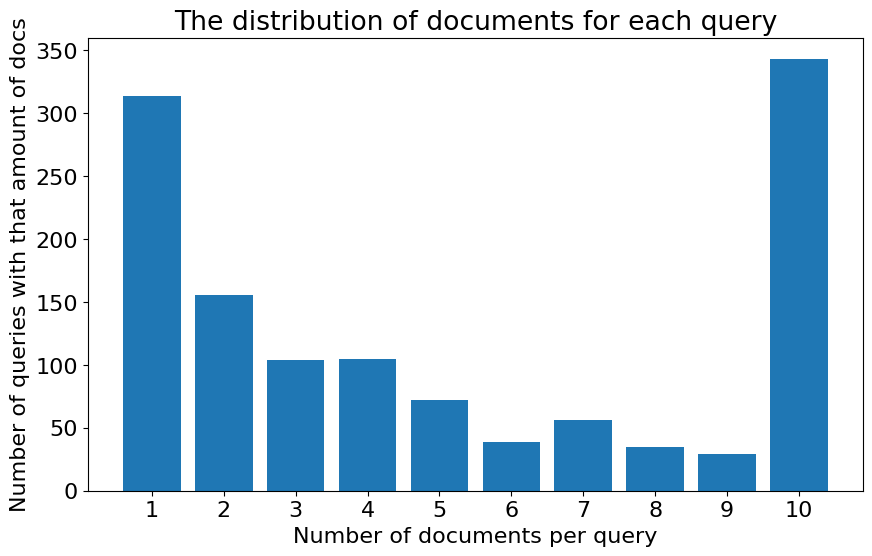

In [38]:
D = num_of_docs_per_query

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
#plt.yticks([0,20,40,60,80,100])

plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':100,'font.size': 16})
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.title("The distribution of documents for each query")
plt.ylabel("Number of queries with that amount of docs")
plt.xlabel("Number of documents per query")

plt.show()

In [15]:
rdata, errors = reader_data_from_ColBERT_retrievals(df_medQA, df_retrievals, df_FZ, topk=100)

  0%|          | 0/611 [00:00<?, ?it/s]

In [147]:
save_file_path = "/scratch/s190619/MSMARCO/Data/FindZebra/FiD_reader_data/Model1_retrieved_f_reader.json"
with open(save_file_path, 'w', encoding='utf-8') as outfile:
    json.dump(rdata, outfile, ensure_ascii=False)

In [148]:
with open(save_file_path) as json_file:
    data_test = json.load(json_file)

In [149]:
data_test[0]

{'question': 'A 5-year-old girl is brought to the emergency department by her mother because of multiple episodes of nausea and vomiting that last about 2 hours. During this period, she has had 6–8 episodes of bilious vomiting and abdominal pain. The vomiting was preceded by fatigue. The girl feels well between these episodes. She has missed several days of school and has been hospitalized 2 times during the past 6 months for dehydration due to similar episodes of vomiting and nausea. The patient has lived with her mother since her parents divorced 8 months ago. Her immunizations are up-to-date. She is at the 60th percentile for height and 30th percentile for weight. She appears emaciated. Her temperature is 36.8°C (98.8°F), pulse is 99/min, and blood pressure is 82/52 mm Hg. Examination shows dry mucous membranes. The lungs are clear to auscultation. Abdominal examination shows a soft abdomen with mild diffuse tenderness with no guarding or rebound. The remainder of the physical exami

In [161]:
index = 100
print(df_medQA["qid"].iloc[index])
print(df_medQA["query"].iloc[index])
print(df_medQA["answer"].iloc[index])
print(df_medQA["options"].iloc[index])

100
A 67-year-old woman with a recently found hepatic carcinoma has been an inpatient for more than a week. During morning rounds, she was abnormally disoriented to time and place along with a shortened attention span. The overnight resident reports that she was coming in and out of this state for the past couple nights. The patient was known to drink often, but reported that she has not consumed alcohol in weeks leading up to her admission. She is not jaundiced and has no metabolic imbalance upon laboratory tests. What is the most likely cause of her recent mental impairment?
Delirium
{'A': 'Delirium', 'B': 'Substance abuse', 'C': 'Brain metastasis', 'D': 'Delirium tremens', 'E': 'Dementia'}


In [10]:
#!python FiD_reader_format.py /scratch/s190619/MSMARCO/Data/FindZebra/collection_FZ_w_titles.tsv /scratch/s190619/MSMARCO/Retrievals/dev-test/Ranking_Model1.tsv /scratch/s190619/MSMARCO/Data/disorders_table_dev-test.csv /scratch/s190619/MSMARCO/Data/FindZebra/FiD_reader_data/test.json

# MedQA textbook

In [39]:
source = "/scratch/s190619/MSMARCO/MedQA_US/textbooks/combined_text_books.txt"

textbooks = []
f = open(source, "r")
for x in f:
    textbooks.append(x)
f.close()

TB = [x.replace("\n","") for x in textbooks if x != "\n"]
TB_l = [x.lower() for x in TB]
TB_m = [x for x in TB_l if len(x) > 100 and len(x) < 2000]

In [40]:
df_medQA.head()

,qid,query,answer,options,meta_info,Disorder,CUI,TUI,short_category,long_category,description,cui_METAMAP
0,3,A pulmonary autopsy specimen from a 58-year-ol...,Thromboembolism,"{'A': 'Thromboembolism', 'B': 'Pulmonary ische...",step1,True,C0040038,T046,DISO,Disorders,Pathologic Function,['C0040038']
1,4,A 20-year-old woman presents with menorrhagia ...,Von Willebrand disease,"{'A': 'Factor V Leiden', 'B': 'Hemophilia A', ...",step1,True,C0042974,T047,DISO,Disorders,Disease or Syndrome,['C0042974']
2,5,A 40-year-old zookeeper presents to the emerge...,Scorpion sting,"{'A': 'Aspirin', 'B': 'Oral contraceptive pill...",step1,True,C0238417,T037,DISO,Disorders,Injury or Poisoning,['C0238417']
4,21,An investigator is studying the function of th...,Anorexia,"{'A': 'Hypothermia', 'B': 'Hyperthermia', 'C':...",step1,True,C0003123,T047,DISO,Disorders,Disease or Syndrome,"['C0003123', 'C1971624']"
7,23,A 42-year-old woman is in the hospital recover...,Delirium tremens,"{'A': 'Acute cholangitis', 'B': 'Alcoholic hal...",step1,True,C0001957,T047,DISO,Disorders,Disease or Syndrome,['C0001957']


In [61]:
for title_opt in tqdm([1,2,3]):
    reader_data, not_found = create_reader_train(df_medQA, TB_m, title_opt, N=10)
    
    path = "/scratch/s190619/Data_etc/Medical_MSMARCO/FiD_train/" + "FiD_train_medQA_title" + str(title_opt) + ".json"
    
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(reader_data, f, ensure_ascii=False, indent=4)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2281 [00:00<?, ?it/s]

  0%|          | 0/2281 [00:00<?, ?it/s]

  0%|          | 0/2281 [00:00<?, ?it/s]

In [62]:
path = "/scratch/s190619/Data_etc/Medical_MSMARCO/FiD_train/" + "FiD_train_medQA_title" + str(1) + ".json"
with open(path) as json_file:
    data_test = json.load(json_file)

In [63]:
num_of_docs_per_query = {}
for i in range(10):
    num_of_docs_per_query[i+1] = 0

for i in range(len(reader_data)):
    num_of_docs_per_query[len(reader_data[i]["ctxs"])] += 1

In [64]:
num_of_docs_per_query

{1: 102, 2: 84, 3: 65, 4: 60, 5: 46, 6: 44, 7: 37, 8: 53, 9: 30, 10: 1595}

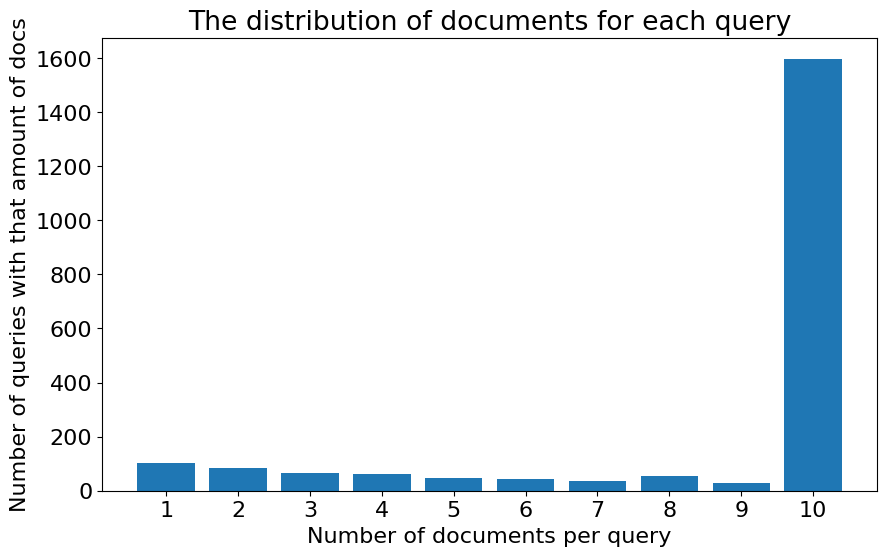

In [65]:
D = num_of_docs_per_query

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
#plt.yticks([0,20,40,60,80,100])

plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':100,'font.size': 16})
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.title("The distribution of documents for each query")
plt.ylabel("Number of queries with that amount of docs")
plt.xlabel("Number of documents per query")

plt.show()

In [ ]:
#df_fz = pd.read_csv("/scratch/s190619/MSMARCO/FZ_corpus_evaluation.tsv", sep="\t")

In [ ]:
#fz_cuis = df_fz["cui"].unique()